# Chapter 03 유한 마르코프 결정 과정

### 예제 3.5 격자 공간

#### 직접 구현한 코드

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

np.random.seed = 43
np.set_printoptions(precision=2, suppress=True)

In [182]:
class Grid(object):
    def __init__(self, size=(5, 5), gamma=0.9, use_special_info=True):
        self.grid = np.zeros(size)
        self.value = np.zeros(size)
        self.gamma = gamma

        if use_special_info:
            self.special_info = {
                (0, 1) : { "reward": 10, "move": np.array([4, 1])},
                (0, 3) : { "reward": 5, "move": np.array([2, 3])},
            }

        self.left = np.array([0, -1], dtype=np.int)
        self.right = np.array([0, 1], dtype=np.int)
        self.up = np.array([-1, 0], dtype=np.int)
        self.down = np.array([1, 0], dtype=np.int)
    
    def is_inbound(self, pos):
        height, width = self.grid.shape
        if 0 <= pos[0] < height and 0 <= pos[1] < width:
            return True
        return False

    def get_bound_values(self, pos):
        value = 0
        if self.is_inbound(pos + self.left):
            value += self.value[tuple(pos + self.left)]
        if self.is_inbound(pos + self.right):
            value += self.value[tuple(pos + self.right)]
        if self.is_inbound(pos + self.up):
            value += self.value[tuple(pos + self.up)]
        if self.is_inbound(pos + self.down):
            value += self.value[tuple(pos + self.down)]
        return value
        
    def reset(self):
        self.pos = np.random.randint(low=0, high=5, size=(2))

    def act(self):
        return np.random.choice([0, 1, 2, 3])
    
    def step(self, action):
        if action == 0:  # left
            new_pos = self.pos + self.left
        elif action == 1:  # right
            new_pos = self.pos + self.right
        elif action == 2:  # up
            new_pos = self.pos + self.up
        else:  # down
            new_pos = self.pos + self.down

        if tuple(self.pos) in self.special_info:
            reward = self.special_info[tuple(self.pos)]["reward"]
            new_pos = self.special_info[tuple(self.pos)]["move"]
        elif self.is_inbound(new_pos):
            reward = 0
        else:
            reward = -1
            new_pos = self.pos

        bound_values = self.get_bound_values(new_pos)
        self.value[tuple(self.pos)] = (reward + self.gamma * bound_values) / 4
        self.pos = new_pos

        return reward == -1
            

In [185]:
grid = Grid()
grid.reset()

for _ in range(100000):
    is_end = False
    # grid.reset()
    # while not is_end:
    action = grid.act()
    is_end = grid.step(action)

#### 책에서 구현한 코드

In [1]:
import matplotlib.pyplot as plt
from matplotlib.table import Table
import numpy as np

In [8]:
WORLD_SIZE = 5
A_POS = [0, 1]
A_PRIME_POS = [4, 1]
B_POS = [0, 3]
B_PRIME_POS = [2, 3]
DISCOUNT = 0.9

# left, up, right, down
ACTIONS = [
    np.array([0, -1]),
    np.array([-1, 0]),
    np.array([0, 1]),
    np.array([1, 0])]
ACTION_FIGS = ['←', '↑', '→', '↓']

ACTION_PROB = 0.25

def step(state, action):
    if state == A_POS:
        return A_PRIME_POS, 10
    elif state == B_POS:
        return B_PRIME_POS, 5

    next_state = (np.array(state) + action).tolist()
    x, y = next_state
    if x < 0 or x >= WORLD_SIZE or y < 0 or y >= WORLD_SIZE:
        reward = -1.0
        next_state = state
    else:
        reward = 0
    return next_state, reward

def draw_image(image):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])
    
    nrows, ncols = image.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    for (i, j), val in np.ndenumerate(image):
        # add state labels
        if [i, j] == A_POS:
            val = str(val) + " (A)"
        elif [i, j] == A_PRIME_POS:
            val = str(val) + " (A')"
        elif [i, j] == B_POS:
            val = str(val) + " (B)"
        elif [i, j] == B_PRIME_POS:
            val = str(val) + " (B')"
        
        tb.add_cell(i, j, width, height,
                    text=val, loc='center', facecolor='white')
    
    # Row and column labels...
    for i in range(len(image)):
        tb.add_cell(i, -1, width, height,
                    text=i+1, loc='right', edgecolor='none', facecolor='none')
        tb.add_cell(-1, i, width, height/2,
                    text=i+1, loc='right', edgecolor='none', facecolor='none')

    ax.add_table(tb)

def draw_policy(optimal_values):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = optimal_values.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for (i, j), val in np.ndenumerate(optimal_values):
        next_vals = []
        for action in ACTIONS:
            next_state, _ = step([i, j], action)
            next_vals.append(optimal_values[next_state[0], next_state[1]])
            if (i, j) == (0, 3):
                print((i, j), next_state, optimal_values[next_state[0], next_state[1]])
        
        best_actions = np.where(next_vals == np.max(next_vals))[0]
        val = ''
        for ba in best_actions:
            val += ACTION_FIGS[ba]
        
        # add state labels
        if [i, j] == A_POS:
            val = str(val) + " (A)"
        elif [i, j] == A_PRIME_POS:
            val = str(val) + " (A')"
        elif [i, j] == B_POS:
            val = str(val) + " (B)"
        elif [i, j] == B_PRIME_POS:
            val = str(val) + " (B')"

        tb.add_cell(i, j, width, height, text=val, loc='center', facecolor='white')

        # Row and column lables...
        for i in range(len(optimal_values)):
            tb.add_cell(i, -1, width, height, text=i+1, loc='right', edgecolor='none', facecolor='none')
            tb.add_cell(-1, i, width, height/2, text=i+1, loc='center', edgecolor='none', facecolor='none')
        ax.add_table(tb)

def draw_image2(image):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    ax.imshow(image)

def figure_3_2():
    value = np.zeros((WORLD_SIZE, WORLD_SIZE))
    while True:
        # keep iteration until convergence
        new_value = np.zeros_like(value)
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):
                for action in ACTIONS:
                    (next_i, next_j), reward = step([i, j], action)
                    # bellman equation
                    new_value[i, j] += ACTION_PROB * (reward + DISCOUNT * value[next_i, next_j])
        if np.sum(np.abs(value - new_value)) < 1e-4:
            draw_image(np.round(new_value, decimals=1))
            plt.show()
            break

        value = new_value

# def figure_3_2_linear_system():
#     A = -1 * np.eye(WORLD_SIZE * WORLD_SIZE)
#     b = np.zeros(WORLD_SIZE * WORLD_SIZE)
#     for i in range(WORLD_SIZE):
#         for j in range(WORLD_SIZE):
#             s = [i, j]
#             index_s = np.ravel_multi_index(s, (WORLD_SIZE, WORLD_SIZE))

#             for a in ACTIONS:
#                 s_, r = step(s, a)
#                 index_s_ = np.ravel_multi_index(s_, (WORLD_SIZE, WORLD_SIZE))

#                 A[index_s, index_s_] += ACTION_PROB * DISCOUNT
#                 b[index_s] -= ACTION_PROB * r
    
#     x = np.linalg.solve(A, b)
#     draw_image(np.round(x.reshape(WORLD_SIZE, WORLD_SIZE), decimals=2))
#     plt.show()

def figure_3_5():
    value = np.zeros((WORLD_SIZE, WORLD_SIZE))
    while True:
        # keep iteration until convergence
        new_value = np.zeros_like(value)
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):
                values = []
                for action in ACTIONS:
                    (next_i, next_j), reward = step([i, j], action)
                    # value iteration
                    values.append(reward + DISCOUNT * value[next_i, next_j])
                new_value[i, j] = np.max(values)
        if np.sum(np.abs(new_value - value)) < 1e-4:
            draw_image(np.round(new_value, decimals=2))
            # plt.show()
            draw_policy(new_value)
            plt.show()
            break
        value = new_value

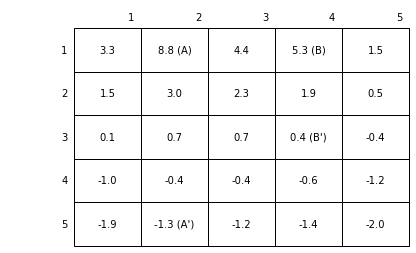

In [14]:
figure_3_2()

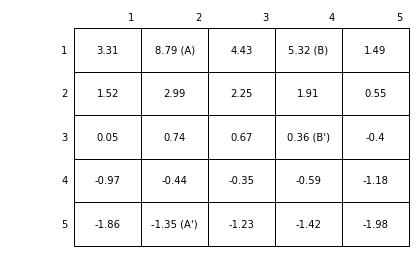

In [12]:
figure_3_2_linear_system()

(0, 3) [2, 3] 16.021535036792454
(0, 3) [2, 3] 16.021535036792454
(0, 3) [2, 3] 16.021535036792454
(0, 3) [2, 3] 16.021535036792454


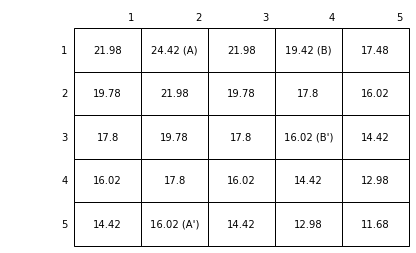

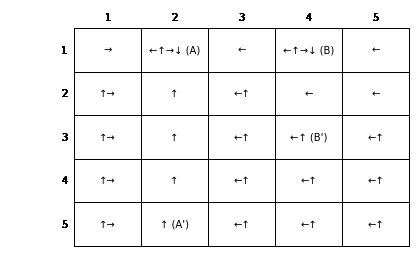

In [9]:
figure_3_5()